In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import svm
from sklearn.metrics import roc_curve

%matplotlib inline
plt.rcParams["figure.figsize"] = (9,9)
plt.rcParams["xtick.labelsize"] = '15'
plt.rcParams["ytick.labelsize"] = '15'
plt.rcParams["legend.fontsize"] = 'x-large'



In [20]:
win_size = (64,128) 
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9
deriv_aperture = 1
win_sigma = -1
histogram_norm_type = 0
l2_hys_threshold = 2.0000000000000001e-01
gamma_correction = 0
nlevels = 64
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size,nbins,deriv_aperture,win_sigma,
                        histogram_norm_type,l2_hys_threshold,gamma_correction,nlevels)
win_stride = (8, 8)

C_SVM = 0.01

pre_trained_size = 20

In [21]:
dets = [] #0.001, 0.01, 0.1, 1, deafult

In [22]:
#TestSrcPathPos = "C:/Users/zoom_/courserattut/TRY/70X134H96/Test/pos"
TestSrcPathPos = "C:/Users/zoom_/Desktop/val"
TestPosFileList = [f for f in os.listdir(TestSrcPathPos)]
TestPos = []
for x in TestPosFileList:
    TestPos.append(os.path.join(TestSrcPathPos, x))

TestSrcPathNeg = "C:/Users/zoom_/courserattut/TRY/Test/neg"
TestNegFileList = [f for f in os.listdir(TestSrcPathNeg)]
TestNeg = []
for x in TestNegFileList:
    TestNeg.append(os.path.join(TestSrcPathNeg, x))

#TrainSrcPathPos = "C:/Users/zoom_/courserattut/TRY/96X160H96/Train/pos"
TrainSrcPathPos = "C:/Users/zoom_/Desktop/train"
TrainPosFileList = [f for f in os.listdir(TrainSrcPathPos)]
TrainPos = []
for x in TrainPosFileList:
    TrainPos.append(os.path.join(TrainSrcPathPos, x))

TrainSrcPathNeg = "C:/Users/zoom_/courserattut/TRY/Train/neg"
TrainNegFileList = [f for f in os.listdir(TrainSrcPathNeg)]
TrainNeg = []
for x in TrainNegFileList:
    TrainNeg.append(os.path.join(TrainSrcPathNeg, x))

In [23]:
Ytrain = []
for i in range(0, len(TrainPos)):
    Ytrain.append(1)
for i in range(0, pre_trained_size * len(TrainNeg)): #size!!!
    Ytrain.append(0)

In [19]:
matrix = []
    
for t in TrainPos:
    img = cv2.imread(t)
    height, width = img.shape[:2]
    locations = [((width-64)//2, (height-128)//2)]
    descriptor = hog.compute(img, locations = locations)
    matrix.append(descriptor)
    
for t in TrainNeg:
    img = cv2.imread(t)
    descriptors = hog.compute(img, winStride = win_stride).reshape(-1,3780)
    indexes = np.random.randint(descriptors.shape[0], size=pre_trained_size) #size!!!
    for rs in descriptors[indexes]:
        matrix.append(np.reshape(rs, (3780, 1)))
              
matrix = np.reshape(matrix, (len(matrix),len(matrix[0])))

In [24]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
# svm.setDegree(0.0)
# svm.setGamma(0.0)
# svm.setCoef0(0.0)
svm.setC(C_SVM)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)
#svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1.e-06))
svm.train(matrix, cv2.ml.ROW_SAMPLE, np.array(Ytrain))

True

In [25]:
svm_detector = []
for i in range(0, 3780):
    svm_detector.append(0)
    
df = svm.getDecisionFunction(0)
alpha = df[1][0][0]
rho = df[0]
sv = svm.getSupportVectors()[0]

k = 0
for j in range(0, 3780):
    svm_detector[j] += (-alpha) * sv[k]
    k += 1
        
svm_detector.append(rho)
hog.setSVMDetector(np.array(svm_detector))

In [26]:
hard_examples = []

for t in TrainNeg:
    img = cv2.imread(t)
    (points, weights) = hog.detect(img, hitThreshold=-2000.0, winStride = (8, 8))
    for i in range (0, len(weights)):
        if(weights[i] > 0):
            x = int(points[i][0])
            y = int(points[i][1])
            hard_examples.append(hog.compute(img, locations = [(x, y)]))

In [27]:
len(hard_examples)

19646

In [28]:
new_matrix = []
for m in matrix:
    new_matrix.append(np.reshape(m, (3780, 1)))
for he in hard_examples:
    new_matrix.append(np.reshape(he, (3780, 1)))

In [29]:
new_matrix = np.reshape(new_matrix, (len(new_matrix),len(new_matrix[0])))

In [30]:
Ytrain = []
for i in range(0, len(TrainPos)):
    Ytrain.append(1)
for i in range(len(TrainPos), len(new_matrix)):
    Ytrain.append(0)

In [32]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
# svm.setDegree(0.0)
# svm.setGamma(0.0)
# svm.setCoef0(0.0)
svm.setC(C_SVM)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)
#svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1.e-06))
svm.train(new_matrix, cv2.ml.ROW_SAMPLE, np.array(Ytrain))

True

In [33]:
svm_detector = []
for i in range(0, 3780):
    svm_detector.append(0)
    
df = svm.getDecisionFunction(0)
alpha = df[1][0][0]
rho = df[0]
sv = svm.getSupportVectors()[0]

k = 0
for j in range(0, 3780):
    svm_detector[j] += (-alpha) * sv[k]
    k += 1
        
svm_detector.append(rho)
hog.setSVMDetector(np.array(svm_detector))

In [569]:
#hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [41]:
answer = []

import time

start_time = time.perf_counter()

for t in TestPos:
    img = cv2.imread(t)
    height, width = img.shape[:2]
    x = int((width-64)//2)
    y = int((height-128)//2)
    #locations = [(x, y), (x + 1, y), (x + 2, y), (x + 3, y), (x - 1, y), (x - 2, y), (x - 3, y),
     #           (x, y + 1), (x, y + 2), (x, y + 3), (x, y - 1), (x, y - 2), (x, y - 3)]
    (points, weights) = hog.detect(img, hitThreshold=-2000.0, searchLocations = [(x, y)])
    BestIndex = weights.argmax()
    answer.append(weights[BestIndex])
    
num_loop = len(TestPos)
finish_time = time.perf_counter() - start_time
finish_time = (finish_time  * 1000)/(num_loop)
print("time = {} msec".format(finish_time))

for t in TestNeg:
    img = cv2.imread(t)
    (points, weights) = hog.detect(img, hitThreshold=-2000.0, winStride=(8,8))
    for w in weights:
        answer.append(w)

time = 4.1384342758942605 msec


In [42]:
answ = []
for i in range(0, len(answer)):
    answ.append(answer[i][0])

In [44]:
Ytest = []
for i in range(0, len(TestPos)):
    Ytest.append(1)
for i in range(0, len(answ) - len(TestPos)):
    Ytest.append(0)

In [45]:
fpr, tpr, tr = roc_curve(Ytest, answ)

In [46]:
det = []
for t in tpr:
    det.append(1 - t)

In [47]:
#dets = []

In [48]:
dets.append([fpr, det])

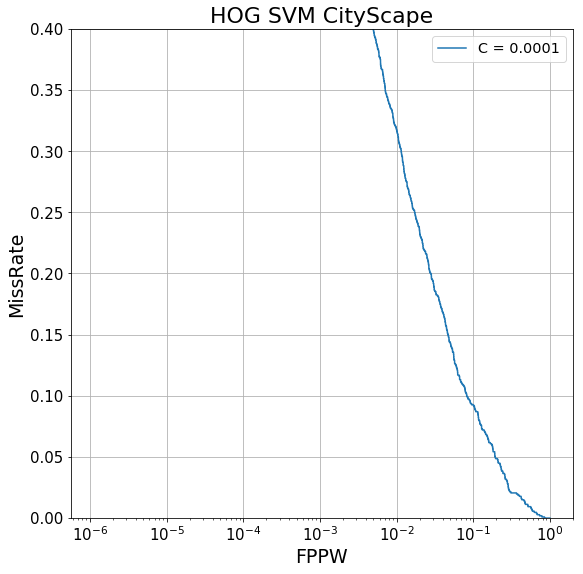

In [55]:
fig = plt.figure()
plt.title('HOG SVM CityScape', fontsize = 22)
plt.ylabel(r'MissRate', fontsize=19)
plt.xlabel(r'FPPW', fontsize=19)
plt.xscale('log')
plt.grid()
plt.plot(dets[0][0], dets[0][1], label = 'C = 0.0001')
#plt.plot(dets[1][0], dets[1][1], label = 'C = 0.001')
#plt.plot(dets[2][0], dets[2][1], label = 'C = 0.01')
#plt.plot(dets[3][0], dets[3][1], label = 'C = 0.1')
#plt.plot(dets[4][0], dets[4][1], label = 'Default')
plt.legend()
plt.ylim(0, 0.4)
fig.savefig('HOG_SVM_CityScape.png')

In [257]:
with open('HOG_SVM_INRIA.txt', 'w') as f:
    for item in dets:
        f.write("%s\n" % item)

In [360]:
def Reshape_in(Q):
    RES=[]
    for i in range(0,9):
        a=[] #30 array with 14 elem
        for j in range(0,7):
            b=[] #14 elem
            c=[]#14 elem
            for k in range(0,15):
                b.append(Q[2*j*30*9+k*36+i])
                b.append(Q[2*j*30*9+k*36+i+9])
                c.append(Q[2*j*30*9+k*36+i+18])
                c.append(Q[2*j*30*9+k*36+i+27])
            a.append(b)
            a.append(c)
        RES.append(a)
    return RES

In [361]:
TrainNegDes = []
TrainPosDes = []

for i in range(0, len(TrainPos)):
    TrainPosDes.append(matrix[i])
for i in range(len(TrainPos), len(matrix)):
    TrainNegDes.append(matrix[i])

In [362]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [366]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)    9x30x14
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(9, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(18, 36, kernel_size=5, stride=1, padding=1)
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(36 * 14 * 6, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)   9x30x14 to 18x30x14
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #print(x.shape)
        #to 18x14x6
        x = F.relu(self.conv2(x))   #to 36x14x6
        #print(x.shape)
        #print(x.shape)
        #Size changes from (18, 32, 32) to (18, 16, 16)  36x14x6 to 36x7x3
        x = self.pool(x)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.shape)
        x = x.view(-1, 36 * 14 * 6)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return F.sigmoid(x)

model = SimpleCNN()
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

# Train the model
batch_size = len(TrainPosDes) - 3
for i in range(0, batch_size):
    # Forward pass
    #xinput = torch.tensor(Reshape_in(neg[i]), dtype = torch.float32)
    inputs = []
    labels = []
    
    for j in range(0, 3):
        for k in range(0, int(len(TrainNegDes) / len(TrainPosDes))):
            inputs.append(Reshape_in(TrainNegDes[i + k + j]))
            labels.append([0])
        inputs.append(Reshape_in(TrainPosDes[(i + j)]))
        labels.append([1])
        
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))

C:\Users\zoom_\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333
Loss: 0.8333


In [368]:
for t in TrainNeg:
    hard_examples = []
    img = cv2.imread(t)
    descriptors = hog.compute(img, winStride = win_stride).reshape(-1,3780)
    for d in descriptors:
        inputs = [Reshape_in(d), Reshape_in(d), Reshape_in(d), Reshape_in(d)]
        inputs = torch.from_numpy(np.array(inputs))
        outputs = model(inputs)
        if(outputs[0] > 0.5):
            hard_examples.append(d)
    inputs = []
    labels = []
    if(len(hard_examples) == 0):
        continue
    for he in hard_examples:
        inputs.append(Reshape_in(he))
        labels.append([0])
        inputs.append(Reshape_in(he))
        labels.append([0])
        inputs.append(Reshape_in(he))
        labels.append([0])
        inputs.append(Reshape_in(he))
        labels.append([0])
    inputs = torch.from_numpy(np.array(inputs))
    labels = torch.tensor(labels, dtype = torch.float32)
    #print(inputs.shape, labels)

    outputs = model(inputs)
    #print(outputs)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        print ('Loss: {:.4f}' 
               .format(loss.item()))

C:\Users\zoom_\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [ ]:
answer = []

for t in TestPos:
    img = cv2.imread(t)
    height, width = img.shape[:2]
    locations = [((width-64)//2, (height-128)//2)]
    d = hog.compute(img, hitThreshold=-2000.0, locations = locations)
    inputs = [Reshape_in(d), Reshape_in(d), Reshape_in(d), Reshape_in(d)]
    inputs = torch.from_numpy(np.array(inputs))
    outputs = model(inputs)
    answer.append(outputs[0])

for t in TestNeg:
    img = cv2.imread(t)
    descriptors = hog.compute(img, winStride = win_stride).reshape(-1,3780)
    for d in descriptors:
        inputs = [Reshape_in(d), Reshape_in(d), Reshape_in(d), Reshape_in(d)]
        inputs = torch.from_numpy(np.array(inputs))
        outputs = model(inputs)
        answer.append(outputs[0])

In [ ]:
Ytest = []
for i in range(0, len(TestPos)):
    Ytest.append(1)
for i in range(0, len(answer) - len(TestPos)):
    Ytest.append(0)

In [ ]:
fpr, tpr, tr = roc_curve(Ytest, answer)

In [ ]:
det = []
for t in tpr:
    det.append(1 - t)

In [ ]:
plt.ylabel(r'MissRate', fontsize=19)
plt.xlabel(r'FPPW', fontsize=19)
plt.xscale('log')
plt.grid()
plt.plot(fpr, det)
plt.ylim(0, 0.4)